loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Showing 1 batches after skipping 0 batches
Image batch 0


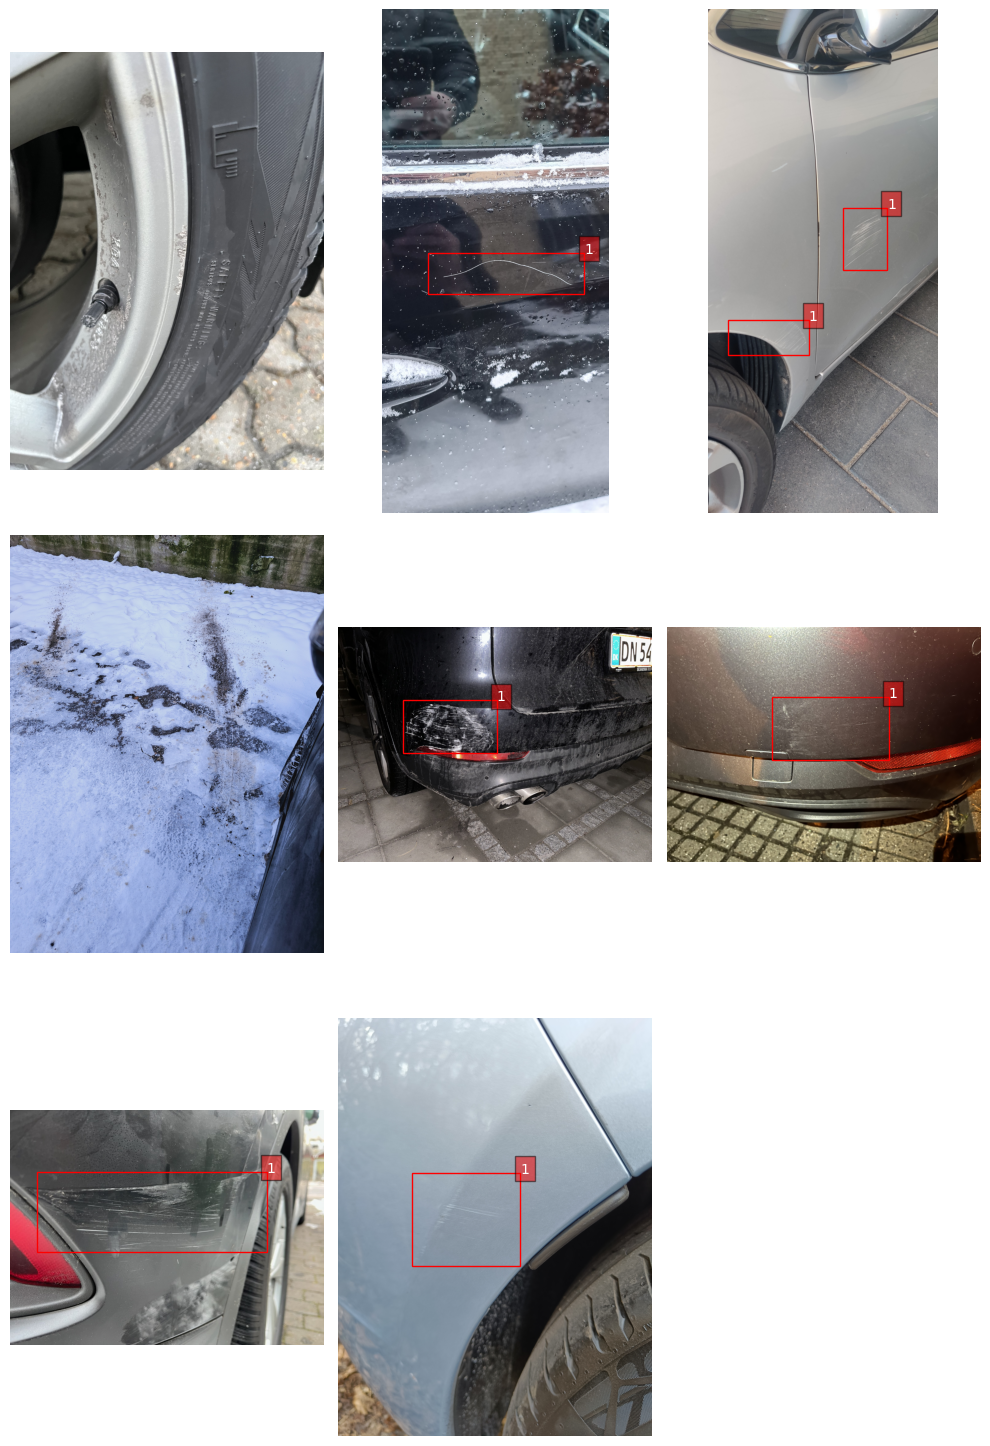

In [3]:
import random

import torch

from ml_carbucks import DATA_DIR
from ml_carbucks.utils.preprocessing import create_clean_loader
from ml_carbucks.utils.inference import plot_img_pred_subplots as psp

carbucks_train_datasets = [
    (
        DATA_DIR / "carbucks" / "images" / "train",
        DATA_DIR / "carbucks" / "instances_train_curated.json",
    )
]

carbucks_loader = create_clean_loader(
    datasets=carbucks_train_datasets, # type: ignore
    batch_size=8,
    shuffle=False,
    transforms=None,
    exif_aware=False
)

cnt, skip = random.randint(3,8), random.randint(0,20)
cnt, skip = 1, 0
print(f"Showing {cnt} batches after skipping {skip} batches")
for i, (imgs, targets) in enumerate(carbucks_loader):
    if i < skip:
        continue
    if i >= cnt + skip:
        break

    print(f"Image batch {i}")
    img_tensors = [torch.from_numpy(img).permute(2, 0, 1) for img in imgs]
    psp(
        img_list=img_tensors,
        bboxes_list=[t["boxes"] for t in targets],
        labels_list=[t["labels"] for t in targets],
        coords="xyxy",
        figsize=(10, 15)
    )

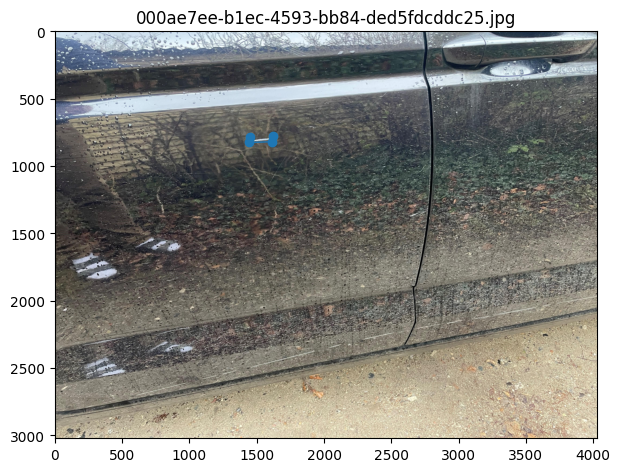

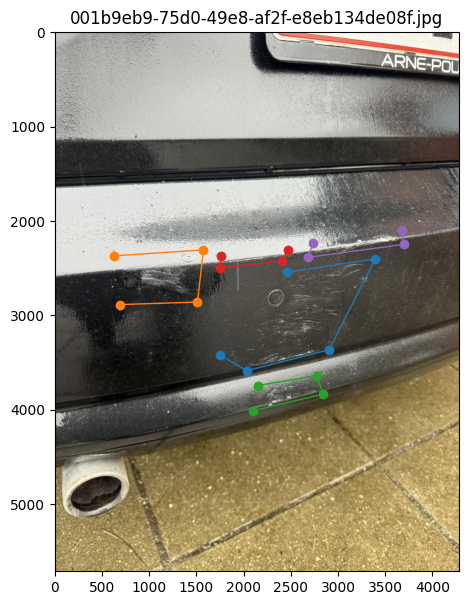

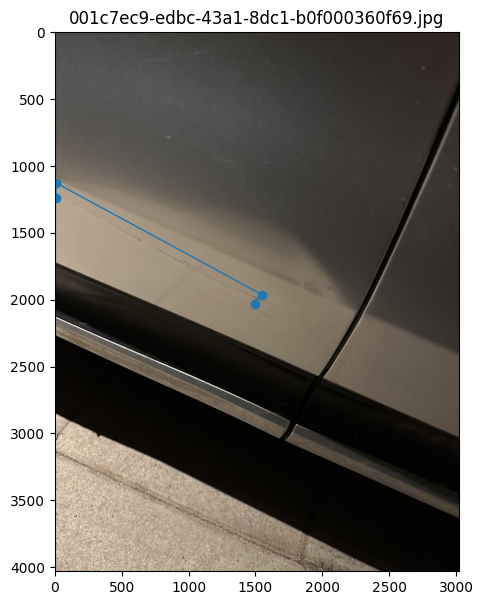

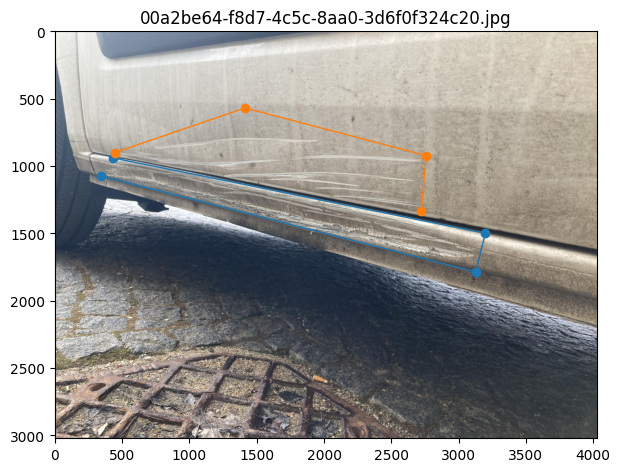

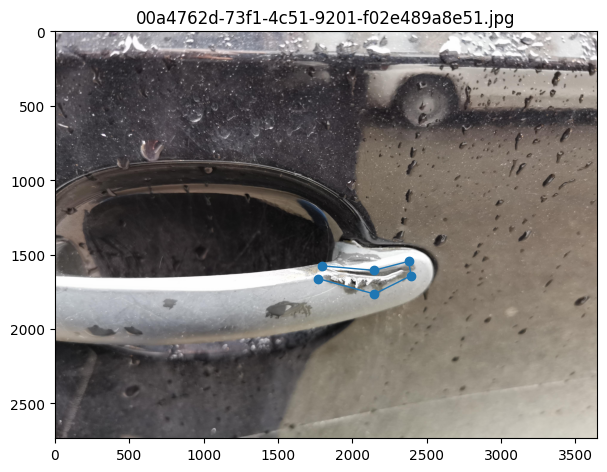

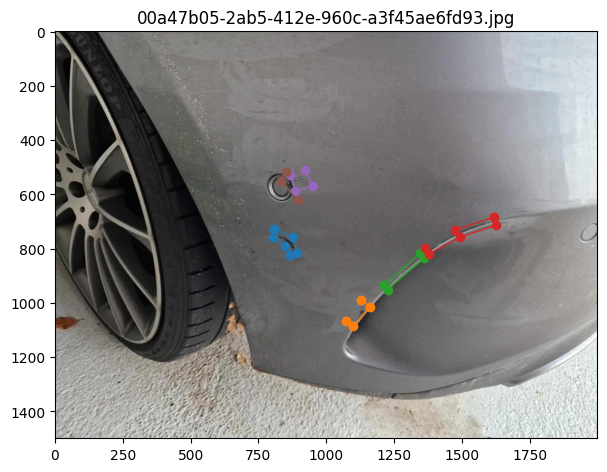

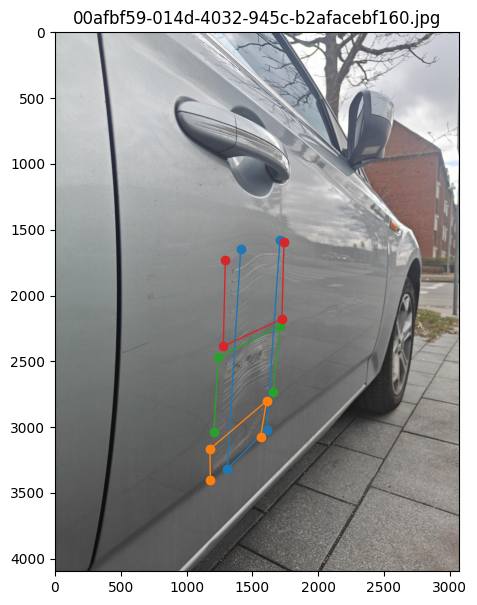

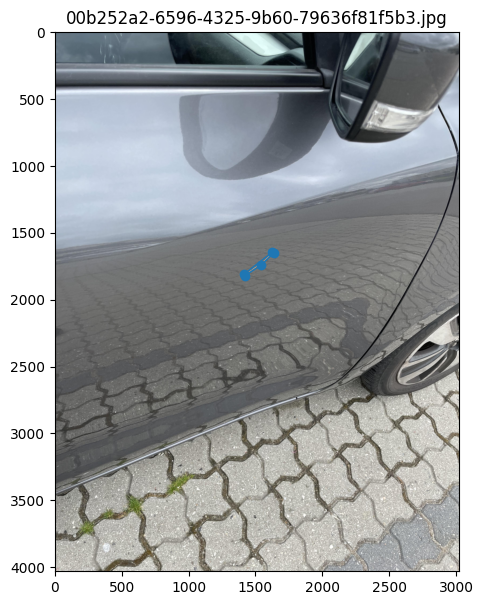

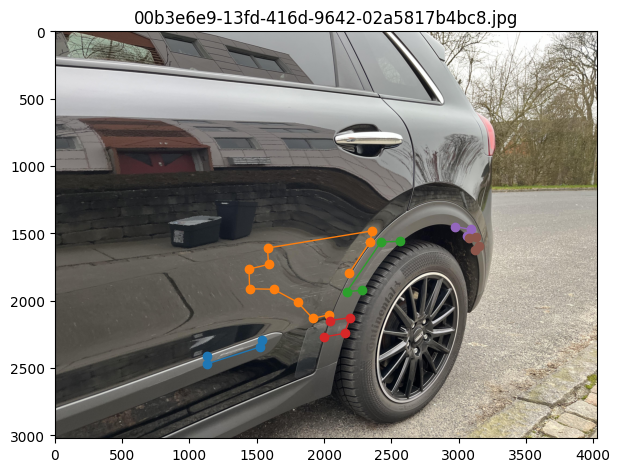

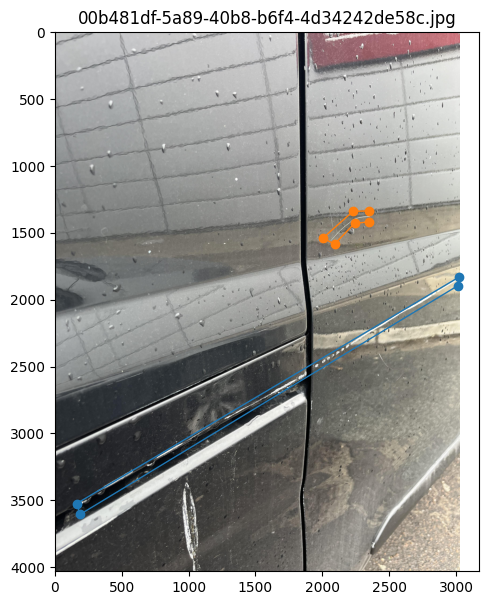

In [4]:
import os
from typing_extensions import Literal
import uuid
from copy import deepcopy
from typing import Union

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import pyplot as plt

from ml_carbucks.utils.preprocessing import create_clean_loader
seg_train_datasets = [
    (
        DATA_DIR / "initial_segmentation" / "images" / "train",
        DATA_DIR / "initial_segmentation" / "instances_train_curated.json",
    )
]
imgs_dir = "/home/bachelor/ml-carbucks/data/intial_segmentation/images/train"

imgs_paths = []
for root, dirs, files in os.walk(imgs_dir):
    for file in files:
        if file.endswith(".jpg"):
            imgs_paths.append(os.path.join(root, file))

img_paths = sorted(imgs_paths)[:10]

for img_path in img_paths:
    seg_path = img_path.replace("images", "labels").replace(".jpg", ".txt")

    if not os.path.exists(seg_path) or os.path.getsize(seg_path) == 0:
        print(f"⚠️ Missing or empty segmentation file: {seg_path}")
        continue

    # Read line by line because polygons may have different point counts
    segmentations = []
    with open(seg_path, "r") as f:
        for line in f:
            nums = list(map(float, line.strip().split()))
            if len(nums) < 3:
                continue  # skip invalid lines
            segmentations.append(nums[1:])  # skip class ID

    if not segmentations:
        print(f"⚠️ No valid polygons in {seg_path}")
        continue

    img = plt.imread(img_path)
    h, w = img.shape[0], img.shape[1]

    plt.figure(figsize=(7,7))
    plt.imshow(img)

    for seg in segmentations:
        seg = np.array(seg)
        seg[0::2] *= w
        seg[1::2] *= h
        poly = seg.reshape(-1, 2)
        plt.plot(poly[:, 0], poly[:, 1], marker="o", linewidth=1)

    plt.title(os.path.basename(img_path))
    plt.show()
